<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/Kaggle/HomeCreditRisk/HomeCreditRisk_DataPrep_0_76393_Kaggle_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yellowbrick
!pip install feature_engine
!pip install featuretools
!pip install catboost
!pip install pycaret
!pip install --user kaggle
!mkdir .kaggle


  Created wheel for numpydoc: filename=numpydoc-0.9.2-cp36-none-any.whl size=31893 sha256=af39110d04ebcca859420a4842d82d90fabbbe4d6120c767188f268c235cf309
  Stored in directory: /root/.cache/pip/wheels/96/f3/52/25c8e1f40637661d27feebc61dae16b84c7cdd93b8bc3d7486
Successfully built numpydoc
     |████████████████████████████████| 64.4MB 49kB/s 
     |████████████████████████████████| 194kB 2.7MB/s 
     |████████████████████████████████| 266kB 32.1MB/s 
     |████████████████████████████████| 1.6MB 51.3MB/s 
     |████████████████████████████████| 389kB 55.9MB/s 
     |████████████████████████████████| 1.2MB 30.8MB/s 
     |████████████████████████████████| 7.0MB 27.0MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 1.2MB 55.8MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 133kB 57.1MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 63.

In [6]:
import json
token = {"username":"vinay10949","key":"59c4901452f76ce62979e5b0997e240b"}        
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c home-credit-default-risk



  0% 0.00/524k [00:00<?, ?B/s]
100% 524k/524k [00:00<00:00, 72.2MB/s]
 77% 44.0M/56.8M [00:00<00:00, 140MB/s]
100% 56.8M/56.8M [00:00<00:00, 225MB/s]
100% 5.81M/5.81M [00:00<00:00, 59.6MB/s]

 96% 73.0M/76.3M [00:00<00:00, 238MB/s]
100% 76.3M/76.3M [00:00<00:00, 219MB/s]
 80% 77.0M/96.7M [00:00<00:00, 210MB/s]
100% 96.7M/96.7M [00:00<00:00, 278MB/s]
 94% 102M/109M [00:00<00:00, 238MB/s] 
100% 109M/109M [00:00<00:00, 245MB/s]
 98% 265M/271M [00:01<00:00, 273MB/s]
100% 271M/271M [00:01<00:00, 266MB/s]
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 37.6MB/s]
 24% 9.00M/36.8M [00:00<00:00, 85.8MB/s]
100% 36.8M/36.8M [00:00<00:00, 180MB/s] 
 44% 16.0M/36.1M [00:00<00:00, 164MB/s]
100% 36.1M/36.1M [00:00<00:00, 176MB/s]


In [7]:
!unzip -uq "/content/*.zip" -d .



8 archives were successfully processed.


In [0]:
!sudo rm *.zip

##**AUTO FT**##

In [9]:
# Load packages
import numpy as np
import pandas as pd
import featuretools as ft
from featuretools import selection
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier

from feature_engine import missing_data_imputers as mdi
# Load applications data
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
cash_balance = pd.read_csv('POS_CASH_balance.csv')
card_balance = pd.read_csv('credit_card_balance.csv')
prev_app = pd.read_csv('previous_application.csv')
payments = pd.read_csv('installments_payments.csv')

# Merge application data
train['Test'] = False
test['Test'] = True
test['TARGET'] = np.nan
app = train.append(test, ignore_index=True, sort=False)

# Create an entity set
es = ft.EntitySet(id='applications')

# Add dataframe to entityset
es = es.entity_from_dataframe(entity_id='applications',
                              dataframe=app,
                              index='SK_ID_CURR')
es['applications']


Entity: applications
  Variables:
    SK_ID_CURR (dtype: index)
    TARGET (dtype: numeric)
    NAME_CONTRACT_TYPE (dtype: categorical)
    CODE_GENDER (dtype: categorical)
    FLAG_OWN_CAR (dtype: categorical)
    FLAG_OWN_REALTY (dtype: categorical)
    CNT_CHILDREN (dtype: numeric)
    AMT_INCOME_TOTAL (dtype: numeric)
    AMT_CREDIT (dtype: numeric)
    AMT_ANNUITY (dtype: numeric)
    AMT_GOODS_PRICE (dtype: numeric)
    NAME_TYPE_SUITE (dtype: categorical)
    NAME_INCOME_TYPE (dtype: categorical)
    NAME_EDUCATION_TYPE (dtype: categorical)
    NAME_FAMILY_STATUS (dtype: categorical)
    NAME_HOUSING_TYPE (dtype: categorical)
    REGION_POPULATION_RELATIVE (dtype: numeric)
    DAYS_BIRTH (dtype: numeric)
    DAYS_EMPLOYED (dtype: numeric)
    DAYS_REGISTRATION (dtype: numeric)
    DAYS_ID_PUBLISH (dtype: numeric)
    OWN_CAR_AGE (dtype: numeric)
    FLAG_MOBIL (dtype: numeric)
    FLAG_EMP_PHONE (dtype: numeric)
    FLAG_WORK_PHONE (dtype: numeric)
    FLAG_CONT_MOBILE (dtype: n

In [0]:
# Featuretools datatypes
BOOL = ft.variable_types.Boolean

# Manually define datatypes in app dataframe
variable_types = {
    'FLAG_MOBIL': BOOL,
    'FLAG_EMP_PHONE': BOOL,
    'FLAG_WORK_PHONE': BOOL,
    'FLAG_CONT_MOBILE': BOOL,
    'FLAG_PHONE': BOOL,
    'FLAG_EMAIL': BOOL,
    'REG_REGION_NOT_LIVE_REGION': BOOL,
    'REG_REGION_NOT_WORK_REGION': BOOL,
    'LIVE_REGION_NOT_WORK_REGION': BOOL,
    'REG_CITY_NOT_LIVE_CITY': BOOL,
    'REG_CITY_NOT_WORK_CITY': BOOL,
    'LIVE_CITY_NOT_WORK_CITY': BOOL,
    'FLAG_DOCUMENT_2': BOOL,
    'FLAG_DOCUMENT_3': BOOL,
    'FLAG_DOCUMENT_4': BOOL,
    'FLAG_DOCUMENT_5': BOOL,
    'FLAG_DOCUMENT_6': BOOL,
    'FLAG_DOCUMENT_7': BOOL,
    'FLAG_DOCUMENT_8': BOOL,
    'FLAG_DOCUMENT_9': BOOL,
    'FLAG_DOCUMENT_10': BOOL,
    'FLAG_DOCUMENT_11': BOOL,
    'FLAG_DOCUMENT_12': BOOL,
    'FLAG_DOCUMENT_13': BOOL,
    'FLAG_DOCUMENT_14': BOOL,
    'FLAG_DOCUMENT_15': BOOL,
    'FLAG_DOCUMENT_16': BOOL,
    'FLAG_DOCUMENT_17': BOOL,
    'FLAG_DOCUMENT_18': BOOL,
    'FLAG_DOCUMENT_19': BOOL,
    'FLAG_DOCUMENT_20': BOOL,
    'FLAG_DOCUMENT_21': BOOL,
}

# Add dataframe to entityset, using manual datatypes
es = es.entity_from_dataframe(entity_id='applications',
                              dataframe=app,
                              index='SK_ID_CURR',
                              variable_types=variable_types)


In [11]:
# Featuretools datatypes
BOOL = ft.variable_types.Boolean
ID = ft.variable_types.Id

# Add bureau dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='bureau',
    dataframe=bureau,
    index='SK_ID_BUREAU',
    variable_types={'SK_ID_CURR': ID})

# Add bureau_balance dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='bureau_balance',
    dataframe=bureau_balance,
    index='New',
    variable_types={'SK_ID_BUREAU': ID})

# Add cash_balance dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='cash_balance',
    dataframe=cash_balance,
    index='New',
    variable_types={'SK_ID_PREV': ID,
                    'SK_ID_CURR': ID})


# Add card_balance dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='card_balance',
    dataframe=card_balance,
    index='New',
    variable_types={'SK_ID_PREV': ID,
                    'SK_ID_CURR': ID})
                         
# Add prev_app dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='prev_app',
    dataframe=prev_app,
    index='SK_ID_PREV',
    variable_types={'SK_ID_CURR': ID,
                    'NFLAG_LAST_APPL_IN_DAY': BOOL})

# Add payments dataframe to entityset
es = es.entity_from_dataframe(
    entity_id='payments',
    dataframe=payments,
    index='New',
    variable_types={'SK_ID_PREV': ID,
                    'SK_ID_CURR': ID})


2020-04-18 09:04:06,968 featuretools.entityset - WARNING    index New not found in dataframe, creating new integer column
2020-04-18 09:04:18,469 featuretools.entityset - WARNING    index New not found in dataframe, creating new integer column
2020-04-18 09:04:24,351 featuretools.entityset - WARNING    index New not found in dataframe, creating new integer column
2020-04-18 09:04:34,131 featuretools.entityset - WARNING    index New not found in dataframe, creating new integer column


In [0]:
# Define relationships between dataframes
relationships = [
  # parent_entity   parent_variable  child_entity      child_variable
  ('applications', 'SK_ID_CURR',    'bureau',         'SK_ID_CURR'),
  ('bureau',       'SK_ID_BUREAU',  'bureau_balance', 'SK_ID_BUREAU'),
 ('applications', 'SK_ID_CURR',    'prev_app',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'cash_balance',   'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'payments',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'card_balance',   'SK_ID_CURR')
]

# Create the relationships
for pe, pv, ce, cv in relationships:
    es = es.add_relationship(ft.Relationship(es[pe][pv], es[ce][cv]))


In [0]:
# Define which primitives to use
agg_primitives =  ['count', 'mean', 'num_unique']
trans_primitives = ['cum_sum']


In [0]:
# Run deep feature synthesis
dfs_feat = ft.dfs(entityset=es,
                            target_entity='applications',
                            trans_primitives=trans_primitives,
                            agg_primitives=agg_primitives,
                            verbose = True,
                            max_depth=2)



In [0]:
# Remove low information features
dfs_feat = selection.remove_low_information_features(dfs_feat)
dfs_feat.to_csv("dfs_feat.csv")

In [0]:
dfs_feat=pd.read_csv("/content/drive/My Drive/dfs_feat.csv")

In [0]:
# Split data back into test + train
train = dfs_feat[dfs_feat['Test']==False]
test = dfs_feat[dfs_feat['Test']==True]

# Ensure all data is stored as floats
#train = train.astype(np.float32)
#test = test.astype(np.float32)

# Target labels
train_y = train['TARGET']

# Remove test/train indicator column and target column
train.drop(columns=['Test', 'TARGET'], inplace=True)
test.drop(columns=['Test', 'TARGET'], inplace=True)
#train.drop(columns=['Test'], inplace=True)
#test.drop(columns=['Test'], inplace=True)


In [0]:
dfs_feat=dfs_feat.select_dtypes(exclude=['object'])


In [16]:
#!pip install feature_engine
imputer = mdi.MeanMedianImputer(imputation_method='median')
imputer.fit(train)
train=imputer.transform(train)
test=imputer.transform(test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


In [17]:
train_y

1         1.0
2         0.0
3         0.0
5         0.0
6         0.0
         ... 
356250    0.0
356251    0.0
356252    0.0
356253    1.0
356254    0.0
Name: TARGET, Length: 307511, dtype: float64

In [0]:
# Classification pipeline w/ LightGBM
lgbm_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    #('imputer', SimpleImputer(strategy='median')),
    ('classifier', CalibratedClassifierCV(
                        base_estimator=LGBMClassifier(),
                        method='isotonic'))
])

# Fit to training data
lgbm_fit = lgbm_pipeline.fit(train, train_y)

# Predict loan default probabilities of test data
test_pred = lgbm_fit.predict_proba(test)

# Save predictions to file
df_out = pd.DataFrame()
df_out['SK_ID_CURR'] = test.index
df_out['TARGET'] = test_pred[:,1]
df_out.to_csv('test_predictions.csv', index=False)


In [0]:
# Classification pipeline w/ XGBClassifier
from xgboost import XGBClassifier
xgb_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    #('imputer', SimpleImputer(strategy='median')),
    ('classifier', CalibratedClassifierCV(
                        base_estimator=XGBClassifier(),
                        method='isotonic'))
])

# Fit to training data
xgb_fit = xgb_pipeline.fit(train, train_y)

# Predict loan default probabilities of test data
test_pred = xgb_fit.predict_proba(test)

# Save predictions to file
df_out = pd.DataFrame()
df_out['SK_ID_CURR'] = test.index
df_out['TARGET'] = test_pred[:,1]
df_out.to_csv('test_predictions_xgb.csv', index=False)


In [0]:
prediction = np.mean(predictions, axis=0)

df_out = pd.DataFrame()
df_out['SK_ID_CURR'] = test.index
df_out['TARGET'] = prediction
df_out.to_csv('test_predictions_mean.csv', index=False)


In [24]:
df_out['TARGET']

0        0.064863
1        0.081291
2        0.018760
3        0.041615
4        0.176414
           ...   
48739    0.056853
48740    0.067346
48741    0.027313
48742    0.061714
48743    0.181491
Name: TARGET, Length: 48744, dtype: float64

##**Importing lib**

In [19]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import featuretools as ft
import numpy as np
sns.set()

import matplotlib.pyplot as plt


In [0]:
def miss_data(df):
    x = ['column_name','missing_data', 'missing_in_percentage']
    missing_data = pd.DataFrame(columns=x)
    columns = df.columns
    for col in columns:
        icolumn_name = col
        imissing_data = df[col].isnull().sum()
        imissing_in_percentage = (df[col].isnull().sum()/df[col].shape[0])*100

        missing_data.loc[len(missing_data)] = [icolumn_name, imissing_data, imissing_in_percentage]
    return missing_data

In [24]:
application_train['TARGET'].value_counts(normalize=True)*100

0    91.927118
1     8.072882
Name: TARGET, dtype: float64

**Target Variable is Imbalanced**

In [25]:
application_train.groupby(['NAME_CONTRACT_TYPE','TARGET'])['TARGET'].size().reset_index(name='prod_count')

,NAME_CONTRACT_TYPE,TARGET,prod_count
0,Cash loans,0,255011
1,Cash loans,1,23221
2,Revolving loans,0,27675
3,Revolving loans,1,1604


In [0]:
[col for col in application_train.columns if application_train[col].isnull().any()]


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


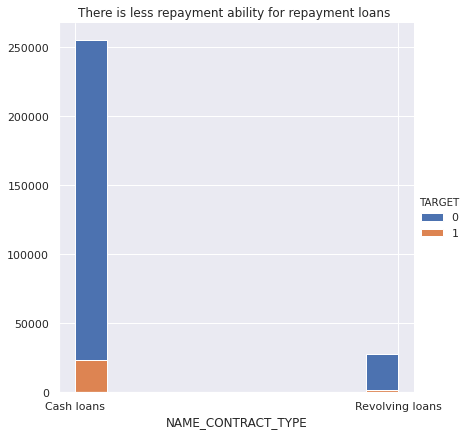

In [26]:
sns.FacetGrid(application_train, hue="TARGET", size=6) \
   .map(plt.hist, "NAME_CONTRACT_TYPE") \
   .add_legend()
plt.title('There is less repayment ability for repayment loans ')
plt.show()

## **Checking for Missing Values**##

In [27]:
#application_train.dtypes
missing=application_train.isnull().mean() * 100
missing.sort_values(ascending=False).head(10)

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_AVG        68.354953
dtype: float64

In [0]:
missing_data=miss_data(application_train)


In [0]:
columnsTobeDropped=missing_data[missing_data['missing_in_percentage']>10]['column_name'].to_list()

In [0]:
application_train_preprocessed=application_train.drop(columnsTobeDropped,axis=1)
application_test_preprocessed=application_test.drop(columnsTobeDropped,axis=1)

In [31]:
preprocessed_missing_data=miss_data(application_train_preprocessed)
columsTobeImputed=preprocessed_missing_data[preprocessed_missing_data['missing_in_percentage']>0]['column_name'].to_list()
columsTobeImputed

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE']

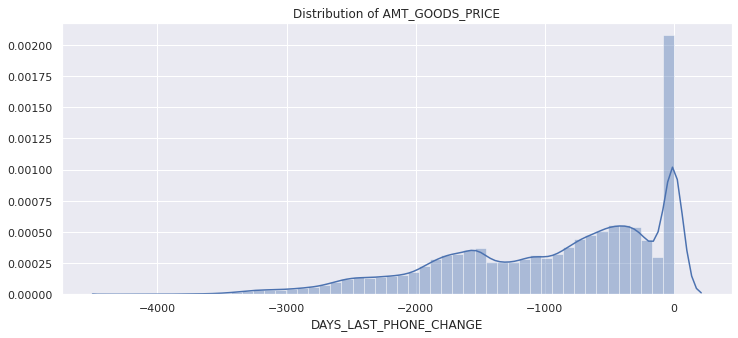

In [32]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(application_train["DAYS_LAST_PHONE_CHANGE"])


In [0]:

AMT_ANNUITY_median=np.nanmedian(application_train["AMT_ANNUITY"])
application_train_preprocessed["AMT_ANNUITY"]=application_train_preprocessed["AMT_ANNUITY"].fillna(AMT_ANNUITY_median)
application_test_preprocessed["AMT_ANNUITY"]=application_test_preprocessed["AMT_ANNUITY"].fillna(AMT_ANNUITY_median)


AMT_GOODS_PRICE_median=np.nanmedian(application_train["AMT_GOODS_PRICE"])
application_train_preprocessed["AMT_GOODS_PRICE"]=application_train_preprocessed["AMT_GOODS_PRICE"].fillna(AMT_GOODS_PRICE_median)
application_test_preprocessed["AMT_GOODS_PRICE"]=application_test_preprocessed["AMT_GOODS_PRICE"].fillna(AMT_GOODS_PRICE_median)


CNT_FAM_MEMBERS_median=np.nanmedian(application_train["CNT_FAM_MEMBERS"])
application_train_preprocessed["CNT_FAM_MEMBERS"]=application_train_preprocessed["CNT_FAM_MEMBERS"].fillna(CNT_FAM_MEMBERS_median)
application_test_preprocessed["CNT_FAM_MEMBERS"]=application_test_preprocessed["CNT_FAM_MEMBERS"].fillna(CNT_FAM_MEMBERS_median)


EXT_SOURCE_2_median=np.nanmedian(application_train["EXT_SOURCE_2"])
application_train_preprocessed["EXT_SOURCE_2"]=application_train_preprocessed["EXT_SOURCE_2"].fillna(EXT_SOURCE_2_median)
application_test_preprocessed["EXT_SOURCE_2"]=application_test_preprocessed["EXT_SOURCE_2"].fillna(EXT_SOURCE_2_median)



DAYS_LAST_PHONE_CHANGE_median=np.nanmedian(application_train["DAYS_LAST_PHONE_CHANGE"])
application_train_preprocessed["DAYS_LAST_PHONE_CHANGE"]=application_train_preprocessed["DAYS_LAST_PHONE_CHANGE"].fillna(DAYS_LAST_PHONE_CHANGE_median)
application_test_preprocessed["DAYS_LAST_PHONE_CHANGE"]=application_test_preprocessed["DAYS_LAST_PHONE_CHANGE"].fillna(DAYS_LAST_PHONE_CHANGE_median)

OBS_30_CNT_SOCIAL_CIRCLE_median=np.nanmedian(application_train["OBS_30_CNT_SOCIAL_CIRCLE"])
application_train_preprocessed["OBS_30_CNT_SOCIAL_CIRCLE"]=application_train_preprocessed["OBS_30_CNT_SOCIAL_CIRCLE"].fillna(OBS_30_CNT_SOCIAL_CIRCLE_median)
application_test_preprocessed["OBS_30_CNT_SOCIAL_CIRCLE"]=application_test_preprocessed["OBS_30_CNT_SOCIAL_CIRCLE"].fillna(OBS_30_CNT_SOCIAL_CIRCLE_median)


DEF_30_CNT_SOCIAL_CIRCLE_median=np.nanmedian(application_train["DEF_30_CNT_SOCIAL_CIRCLE"])
application_train_preprocessed["DEF_30_CNT_SOCIAL_CIRCLE"]=application_train_preprocessed["DEF_30_CNT_SOCIAL_CIRCLE"].fillna(DEF_30_CNT_SOCIAL_CIRCLE_median)
application_test_preprocessed["DEF_30_CNT_SOCIAL_CIRCLE"]=application_test_preprocessed["DEF_30_CNT_SOCIAL_CIRCLE"].fillna(DEF_30_CNT_SOCIAL_CIRCLE_median)


OBS_60_CNT_SOCIAL_CIRCLE_median=np.nanmedian(application_train["OBS_60_CNT_SOCIAL_CIRCLE"])
application_train_preprocessed["OBS_60_CNT_SOCIAL_CIRCLE"]=application_train_preprocessed["OBS_60_CNT_SOCIAL_CIRCLE"].fillna(OBS_60_CNT_SOCIAL_CIRCLE_median)
application_test_preprocessed["OBS_60_CNT_SOCIAL_CIRCLE"]=application_test_preprocessed["OBS_60_CNT_SOCIAL_CIRCLE"].fillna(OBS_60_CNT_SOCIAL_CIRCLE_median)

DEF_60_CNT_SOCIAL_CIRCLE_median=np.nanmedian(application_train["DEF_60_CNT_SOCIAL_CIRCLE"])
application_train_preprocessed["DEF_60_CNT_SOCIAL_CIRCLE"]=application_train_preprocessed["DEF_60_CNT_SOCIAL_CIRCLE"].fillna(DEF_60_CNT_SOCIAL_CIRCLE_median)
application_test_preprocessed["DEF_60_CNT_SOCIAL_CIRCLE"]=application_test_preprocessed["DEF_60_CNT_SOCIAL_CIRCLE"].fillna(DEF_60_CNT_SOCIAL_CIRCLE_median)


application_train_preprocessed["NAME_TYPE_SUITE"]=application_train_preprocessed["NAME_TYPE_SUITE"].fillna("Unknown")
application_test_preprocessed["NAME_TYPE_SUITE"]=application_test_preprocessed["NAME_TYPE_SUITE"].fillna("Unknown")



In [35]:
preprocessed_missing_data[preprocessed_missing_data['missing_in_percentage']>0]['column_name'].to_list()

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE']

In [0]:

from sklearn.feature_selection import VarianceThreshold
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newDf=application_train_preprocessed.select_dtypes(include=numerics)

sel = VarianceThreshold(
    threshold=0.05)  # 0.1 indicates 99% of observations approximately

sel.fit(newDf)  # fit finds the features with low variance
sum(sel.get_support())

colsDrop=[x for x in newDf.columns if x not in newDf.columns[sel.get_support()]]

application_train_preprocessed.drop(colsDrop,axis=1,inplace=True)
application_test_preprocessed.drop(colsDrop,axis=1,inplace=True)

In [0]:
#application_train_preprocessed.to_feather("application_train_preprocessed.feather")
#application_test_preprocessed.to_feather("application_test_preprocessed.feather")
!sudo cp /content/application_train_preprocessed.feather /content/drive/Shared\ drives/AIPower/HomeCreditRisk/

In [0]:
application_train_preprocessed=pd.read_feather("/content/drive/Shared drives/AIPower/HomeCreditRisk/application_train_preprocessed.feather")
application_test_preprocessed=pd.read_feather("/content/drive/Shared drives/AIPower/HomeCreditRisk/application_test_preprocessed.feather")


**Linear Relationship plotted between AMT_CREDIT and AMT_GOODS_PRICE**

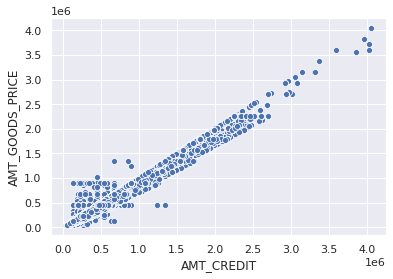

In [12]:

ax = sns.scatterplot(x="AMT_CREDIT", y="AMT_GOODS_PRICE",data=application_train_preprocessed)

In [15]:
application_train_preprocessed.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8'],
      dtype='object')

In [0]:

from cuml.manifold import TSNE
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = application_train_preprocessed.select_dtypes(include=numerics)

newdf

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.555912,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.650442,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.322738,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,15,0,0,0,0,0,0,0.681632,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,1.0,2,2,8,0,0,0,0,0,0,0.115992,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,-5150,1,1,0,1,0,1,1.0,3,3,9,0,0,0,0,1,1,0.535722,6.0,0.0,6.0,0.0,-1909.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,-931,1,1,0,1,0,0,2.0,2,2,9,0,0,0,1,1,0,0.514163,0.0,0.0,0.0,0.0,-322.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


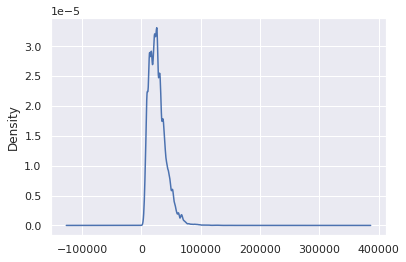

In [46]:
application_train_preprocessed['AMT_ANNUITY'] .plot(kind='kde')

HomeCredit_columns_description[HomeCredit_columns_description['Row'].isin(list(application_train_preprocessed.columns))]


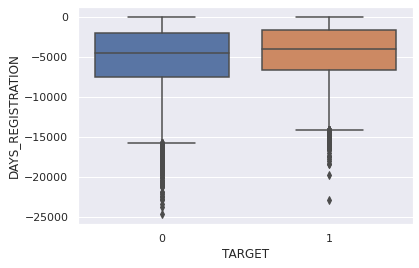

In [52]:
ax = sns.boxplot(x="TARGET", y="DAYS_REGISTRATION", data=application_train_preprocessed)


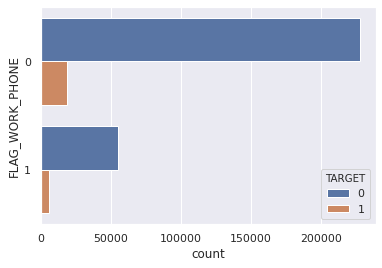

In [56]:
ax = sns.countplot(y="FLAG_WORK_PHONE", hue="TARGET", data=application_train_preprocessed)

In [0]:

from cuml.manifold.umap import UMAP as cumlUMAP
cuml_umap = cumlUMAP(n_neighbors=10, 
                     min_dist=0.02)

embedding_map = cuml_umap.fit_transform(newdf.drop(['TARGET','SK_ID_CURR'],axis=1).to_numpy())


# creating a new data frame which help us in ploting the result data
umap_data = np.vstack((embedding_map.T, scores)).T
umap_df = pd.DataFrame(data=umap_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(umap_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()



In [2]:
!pip install pycaret

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 102kB 5.8MB/s 
     |████████████████████████████████| 389kB 8.8MB/s 
     |████████████████████████████████| 1.2MB 13.5MB/s 
     |████████████████████████████████| 63.9MB 63kB/s 
     |████████████████████████████████| 266kB 36.8MB/s 
     |████████████████████████████████| 133kB 42.2MB/s 
     |████████████████████████████████| 1.2MB 43.8MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 7.0MB 36.5MB/s 
     |████████████████████████████████| 1.6MB 46.7MB/s 
     |████████████████████████████████| 235kB 48.1MB/s 
     |████████████████████████████████| 2.1MB 43.2MB/s 
     |████████████████████████████████| 614kB 40.9MB/s 
     |████████████████████████████████| 6.1MB 40.7MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
   

In [0]:
train['TARGET']=train['TARGET'].astype('category').cat.codes

In [10]:
from pycaret.classification import *
clf1 = setup(data = train, target = 'TARGET', ignore_low_variance = True)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2975
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(307511, 175)"
4,Missing Values,True
5,Numeric Features,123
6,Categorical Features,51
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [11]:
from pycaret.utils import enable_colab 
enable_colab()

Colab mode activated.


In [12]:
xgboost=create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9195,0.7359,0.0040,0.8750,0.0080,0.0073
1,0.9194,0.7476,0.0029,0.6250,0.0057,0.0050
2,0.9194,0.7500,0.0029,0.8333,0.0057,0.0052
3,0.9194,0.7519,0.0035,0.6667,0.0069,0.0060
4,0.9195,0.7455,0.0035,0.8571,0.0069,0.0062
5,0.9190,0.7545,0.0012,0.2222,0.0023,0.0015
6,0.9194,0.7426,0.0029,0.7143,0.0057,0.0051
7,0.9193,0.7446,0.0006,0.3333,0.0011,0.0009
8,0.9193,0.7531,0.0017,0.6000,0.0034,0.0030
9,0.9195,0.7383,0.0035,0.7500,0.0069,0.0061


In [13]:
lightgbm=create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9194,0.7485,0.0167,0.5179,0.0323,0.0274
1,0.9203,0.7572,0.0230,0.6897,0.0445,0.0395
2,0.9196,0.7593,0.0184,0.5714,0.0357,0.0308
3,0.9193,0.7615,0.0253,0.5057,0.0482,0.0408
4,0.9194,0.7515,0.0173,0.5263,0.0334,0.0284
5,0.9199,0.7617,0.0230,0.5970,0.0443,0.0386
6,0.9193,0.7522,0.0190,0.5000,0.0366,0.0309
7,0.9195,0.7592,0.0161,0.5385,0.0313,0.0267
8,0.9197,0.7613,0.0196,0.5763,0.0379,0.0327
9,0.9203,0.7462,0.0248,0.6719,0.0478,0.0423


In [14]:
catboost=create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9193,0.7548,0.0276,0.5000,0.0523,0.0443
1,0.9202,0.7626,0.0345,0.6000,0.0653,0.0570
2,0.9195,0.7658,0.0265,0.5349,0.0504,0.0432
3,0.9196,0.7689,0.0334,0.5321,0.0628,0.0538
4,0.9190,0.7611,0.0213,0.4625,0.0407,0.0338
5,0.9195,0.7666,0.0299,0.5306,0.0566,0.0484
6,0.9193,0.7602,0.0293,0.5000,0.0554,0.0469
7,0.9196,0.7631,0.0265,0.5412,0.0505,0.0433
8,0.9193,0.7681,0.0248,0.5000,0.0472,0.0399
9,0.9198,0.7563,0.0294,0.5543,0.0558,0.0480


In [0]:
et=create_model('et')

In [0]:
tuned_catboost = tune_model('catboost')

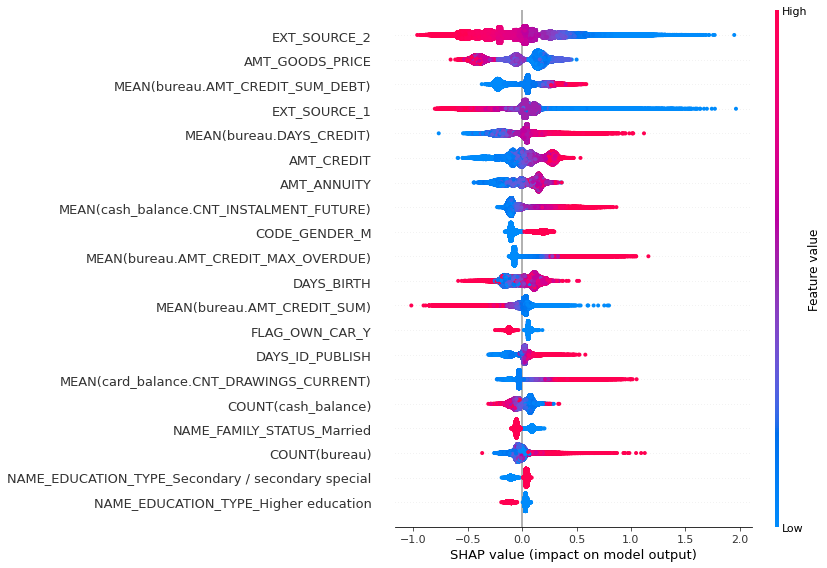

In [20]:
#evaluate a model
interpret_model(catboost)

In [26]:
lr_predictions_holdout = predict_model(catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.9197,0.76,0.0289,0.5485,0.0548,0.0472


In [0]:
help(create_model)

In [27]:
finalize_model(catboost)

In [28]:
#save trained model
save_model(catboost, 'catboost_1')

Transformation Pipeline and Model Succesfully Saved


In [29]:
saved_catboost = load_model('catboost_1') 

Transformation Pipeline and Model Sucessfully Loaded


In [43]:
predictions = predict_model(saved_catboost, data=test)
predictions.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,MEAN(card_balance.AMT_DRAWINGS_POS_CURRENT),MEAN(card_balance.AMT_INST_MIN_REGULARITY),MEAN(card_balance.AMT_PAYMENT_CURRENT),MEAN(card_balance.AMT_PAYMENT_TOTAL_CURRENT),MEAN(card_balance.AMT_RECEIVABLE_PRINCIPAL),MEAN(card_balance.AMT_RECIVABLE),MEAN(card_balance.AMT_TOTAL_RECEIVABLE),MEAN(card_balance.CNT_DRAWINGS_ATM_CURRENT),MEAN(card_balance.CNT_DRAWINGS_CURRENT),MEAN(card_balance.CNT_DRAWINGS_OTHER_CURRENT),MEAN(card_balance.CNT_DRAWINGS_POS_CURRENT),MEAN(card_balance.CNT_INSTALMENT_MATURE_CUM),MEAN(card_balance.SK_DPD),MEAN(card_balance.SK_DPD_DEF),NUM_UNIQUE(card_balance.NAME_CONTRACT_STATUS),NUM_UNIQUE(card_balance.SK_ID_PREV),COUNT(bureau),MEAN(bureau.DAYS_CREDIT),MEAN(bureau.CREDIT_DAY_OVERDUE),MEAN(bureau.DAYS_CREDIT_ENDDATE),MEAN(bureau.DAYS_ENDDATE_FACT),MEAN(bureau.AMT_CREDIT_MAX_OVERDUE),MEAN(bureau.CNT_CREDIT_PROLONG),MEAN(bureau.AMT_CREDIT_SUM),MEAN(bureau.AMT_CREDIT_SUM_DEBT),MEAN(bureau.AMT_CREDIT_SUM_LIMIT),MEAN(bureau.AMT_CREDIT_SUM_OVERDUE),MEAN(bureau.DAYS_CREDIT_UPDATE),MEAN(bureau.AMT_ANNUITY),NUM_UNIQUE(bureau.CREDIT_ACTIVE),NUM_UNIQUE(bureau.CREDIT_CURRENCY),NUM_UNIQUE(bureau.CREDIT_TYPE),COUNT(bureau_balance),MEAN(bureau_balance.MONTHS_BALANCE),NUM_UNIQUE(bureau_balance.STATUS),MEAN(bureau.COUNT(bureau_balance)),MEAN(bureau.MEAN(bureau_balance.MONTHS_BALANCE)),MEAN(bureau.NUM_UNIQUE(bureau_balance.STATUS)),Label,Score
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,9.0,NaN,2.0,2,2,TUESDAY,18,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,0.7552,0.0211,0.00,0.1379,0.1250,0.2083,...,309.375,1698.935625,9808.736420,4093.971864,25546.994118,26559.052500,26559.800000,0.270833,0.216216,0.0,0.045455,3.888889,0.000000,0.000000,1.0,1.0,7.0,-735.000000,0.0,82.428571,-825.500000,0.0,0.0,207623.571429,85240.928571,0.000000,0.0,-93.142857,3545.357143,2.0,1.0,1.0,172.0,-16.279070,4.0,24.571429,-11.785714,2.428571,0,0.0144
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,9.0,Low-skill Laborers,2.0,2,2,FRIDAY,9,Self-employed,0.564990,0.291656,0.432962,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,...,309.375,1698.935625,9808.736420,4093.971864,25546.994118,26559.052500,26559.800000,0.270833,0.216216,0.0,0.045455,3.888889,0.000000,0.000000,1.0,1.0,3.0,-190.666667,0.0,439.333333,-123.000000,0.0,0.0,219042.000000,189469.500000,0.000000,0.0,-54.333333,1420.500000,2.0,1.0,2.0,21.0,-4.333333,3.0,7.000000,-3.000000,2.000000,0,0.3007
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,Drivers,2.0,2,2,MONDAY,14,Transport: type 3,0.505998,0.699787,0.610991,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,...,0.000,1454.539551,7168.346250,6817.172344,17255.559844,18101.079844,18101.079844,0.255556,0.239583,0.0,0.000000,18.719101,0.010417,0.010417,1.0,1.0,4.0,-1737.500000,0.0,-1068.000000,-1054.750000,19305.0,0.0,518070.015000,0.000000,0.000000,0.0,-775.500000,0.000000,1.0,1.0,2.0,230.0,-29.373913,4.0,57.500000,-28.250000,2.750000,0,0.0233
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,4

In [76]:
#test=test.drop('TARGET',axis=1)
predictions.Label
df_out = pd.DataFrame()
df_out['SK_ID_CURR'] = test['SK_ID_CURR']
df_out['TARGET'] = list(predictions['Score'])
df_out.to_csv('test_predictions.csv', index=False)

In [77]:
df_out

,SK_ID_CURR,TARGET
0,100001,0.0144
4,100005,0.3007
12,100013,0.0233
27,100028,0.0188
37,100038,0.1130
...,...,...
356220,456221,0.1264
356221,456222,0.0618
356222,456223,0.0162
356223,456224,0.0688


In [37]:
predictions['TARGET'].value_counts()

0.0    48744
Name: TARGET, dtype: int64

In [0]:
catboost

0.0    48744
Name: TARGET, dtype: int64

In [0]:
blend_specific = blend_models(estimator_list = [xgboost,lightgbm,catboost])

In [79]:
stacked_models = stack_models(estimator_list=[xgboost,catboost,lightgbm])

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9192,0.6314,0.0006,0.3333,0.0011,0.0009
1,0.9191,0.6298,0.0000,0.0000,0.0000,-0.0003
2,0.9191,0.6268,0.0017,0.3333,0.0034,0.0026
3,0.9192,0.6217,0.0006,0.2500,0.0011,0.0008
4,0.9191,0.6402,0.0006,0.1667,0.0011,0.0006
5,0.9190,0.6357,0.0017,0.2727,0.0034,0.0024
6,0.9191,0.6222,0.0000,0.0000,0.0000,-0.0003
7,0.9192,0.6329,0.0012,0.2857,0.0023,0.0016
8,0.9192,0.6332,0.0006,0.2500,0.0011,0.0008
9,0.9190,0.6275,0.0006,0.1250,0.0011,0.0004


In [0]:
finalize_model(stacked_models)

IntProgress(value=0, description='Processing: ', max=17)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:05:27
Status,. . . . . . . . . . . . . . . . . .,Evaluating CatBoostClassifier
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


In [0]:
stacknet = create_stacknet(estimator_list =[[lightgbm,et],[catBoost,gbc,xgboost]])

In [0]:
# finalize a model
lr_final = finalize_model(stacknet)


IntProgress(value=0, description='Processing: ', max=16)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:53:11
Status,. . . . . . . . . . . . . . . . . .,Evaluating CatBoostClassifier
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


In [0]:
# generate predictions on unseen data
predictions = predict_model(lr_final, data = application_test_processed)